# Tutorial - visualizzare la KAN

In questo notebook vedremo nel dettaglio come funziona una KAN internamente, con un record d'esempio, andremo a visualizzare il modo in cui le **spline** vengono modellate in fase di addestramento e come vengono composte in fase di predizione.

Per prima cosa importiamo le librerie necessarie al notebook

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import preprocess_dataset as ut
from tfkan import DenseKAN

In [2]:
# Valore del seme causale
seed_value = 0

# Impostazione dei semi casuali per os, random, numpy e tensorflow
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Prepariamo il dataset per l'addestramento e selezioniamo un record di esempio

In [3]:
x_train = pd.read_csv("datasets/x_train.csv")   # Caricamento del dataset
y_train = pd.read_csv("datasets/y_train.csv")

ut.standardize(x_train)                         # Standardizzazione
x_train = x_train.to_numpy()[:, 1:-1]
y_train = y_train.to_numpy()[:, -1]

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)   # Conversione a tensore
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

my_record = x_train[8]                                      # Selezione del record di esempio

Un livello della KAN può essere formalizzato come una matrice di funzioni

$$
\Phi_{l} = 
\begin{bmatrix}
\phi_{11} & \phi_{12} & \cdots & \phi_{1n} \\
\phi_{21} & \phi_{22} & \cdots & \phi_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{m1} & \phi_{m2} & \cdots & \phi_{mn}
\end{bmatrix}
$$
In cui ogni funzione $\phi$ è definita come

$$
\phi(x) = w_bb(x) + w_s\sum_i{c_iB_i(x)}
$$

L'output n-esimo di una KAN a un livello con un imput di dimensione m è dato dalla formula
$$
KAN(x)_n = \sum_{i_{0}=1}^{m}\phi_{n,i_0}(x_{i_0})
$$

A questo punto possiamo definire l'architettura del modello, compilarlo ed addestrarlo.

Faremo un breve addestramento in quanto ora l'obiettivo non è quello di ottimizzare le prestazioni ma piuttosto quello di illustrare un processo.

In [4]:
input_dim = x_train.shape[1]
layer1_dim = 4
layer2_dim = 1

# Architettura del modello
model = tf.keras.models.Sequential([
    DenseKAN(layer1_dim, grid_range=(-2,2), grid_size=20),
    DenseKAN(layer2_dim, grid_range=(-2,2), grid_size=20)
])

# Costruzione, compilazione e addestramento del modello
model.build(input_shape=(None, input_dim))
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=64)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan (DenseKAN)            │ (None, 4)              │         1,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_1 (DenseKAN)          │ (None, 1)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,728 (6.75 KB)

 Trainable params: 1,728 (6.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 12.4305 - mse: 12.4305
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.7630 - mse: 0.7630
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5734 - mse: 0.5734
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5175 - mse: 0.5175
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4953 - mse: 0.4953
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4829 - mse: 0.4829
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4744 - mse: 0.4744
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4685 - mse: 0.4685
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4642 - mse: 0.4642
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4606 - mse: 0.4606


Vediamo ora come è avvenuto il processamento del nostro record nel primo layer del modello.

Per farlo estraiamo le spline del layer con il metodo **get_spline_list()**. Questo metodo restituisce la matrice delle spline di dimensione input_dim * layer1_dim, nel nostro caso 25 * 4 = 100.

Per rappresentare graficamente le spline del livello usiamo una matrice grafica 4 x 25 con un grafico di spline in ogni cella; per ogni riga, ognuna delle 25 spline prenderà in input l'i-esimo attributo del record d'esempio (qui segnato con una linea rossa) e restituirà in output l'immagine di quell' attributo (qui segnato con una linea verde).

Il vettore passato al livello successivo (di dimensione layer1_dim) avrà come i-esimo valore la somma delle immagini rappresentate nella i-esima riga del livello precedente.

In questa cella calcoliamo per ognuna delle $n$ unità in output $$l_n = \sum_{i_{0}=1}^{25}{\phi_{n,i_0}(x_{i_0})}$$

Avremo infine i quattro valori restituiti dal livello

Output del primo livello: [ 0.57920341  0.23513184 -0.83601147 10.71635091]


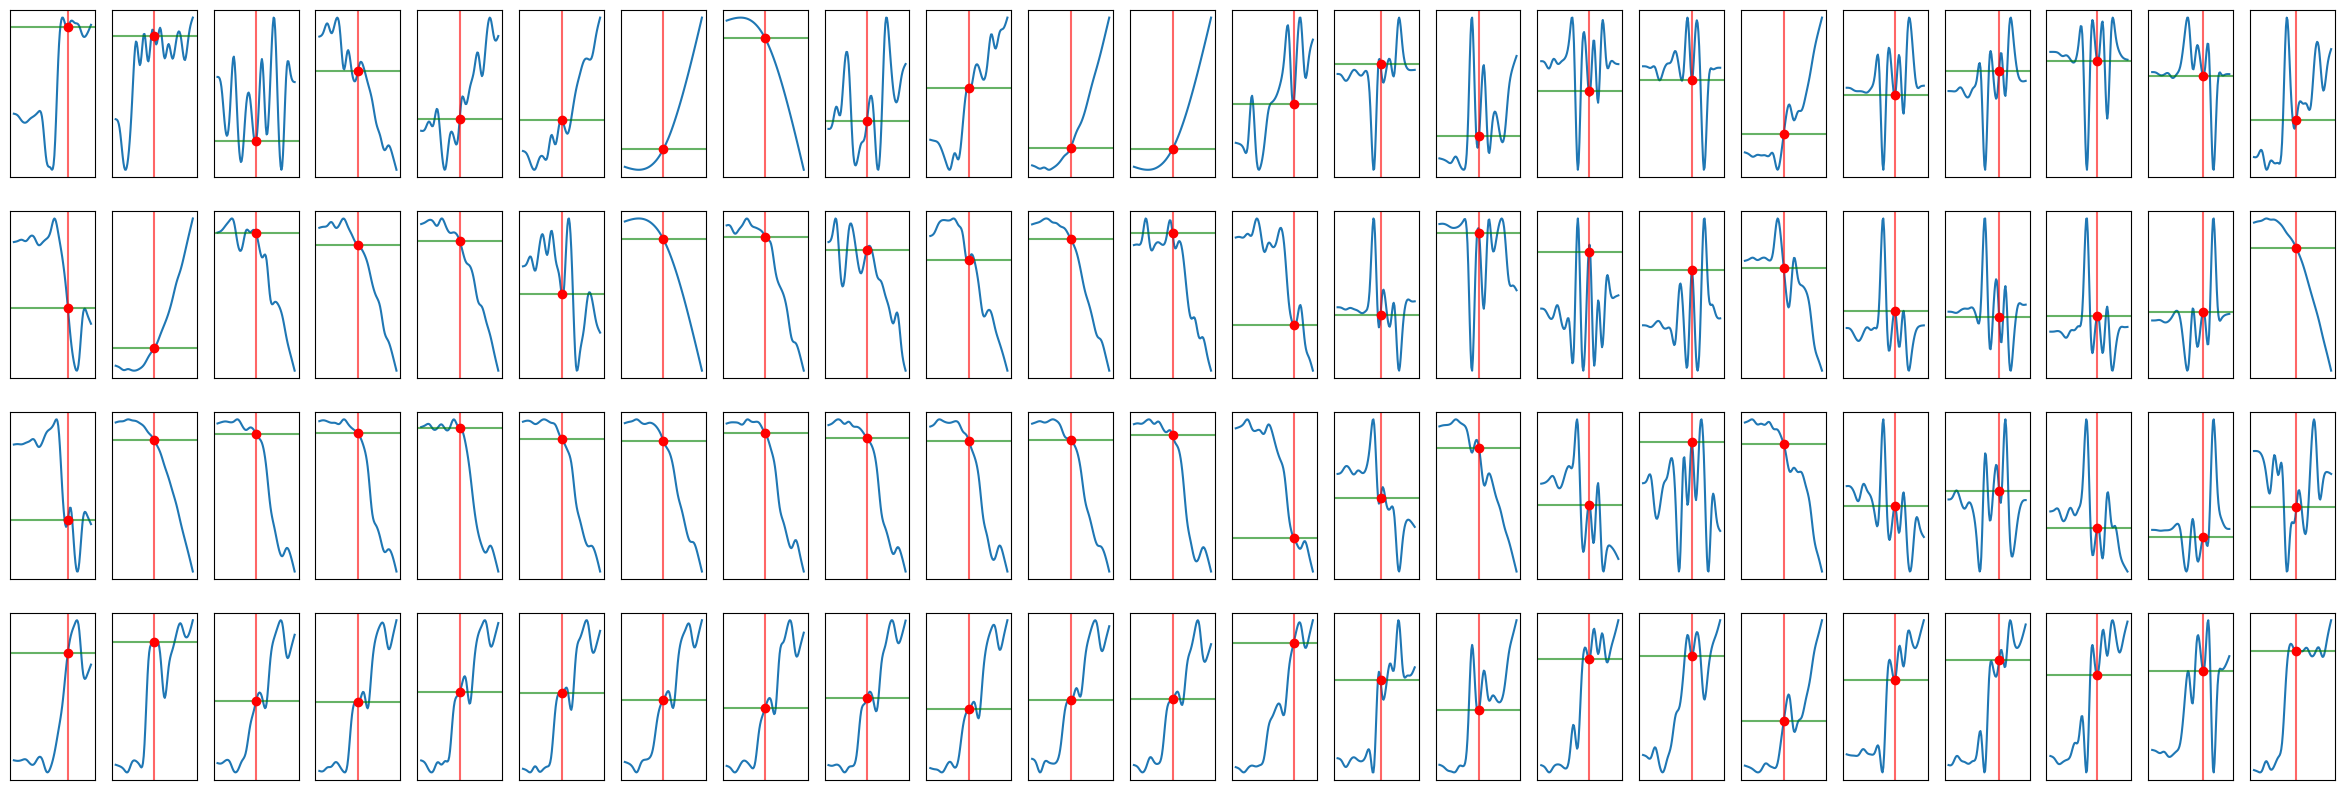

In [5]:
fig, axes = plt.subplots(layer1_dim, input_dim, figsize=(30, 10))   # Preparazione dell'area grafica

spline_list = model.layers[0].get_spline_list()                     # Estrazione delle spline del livello

layer1_output = np.zeros(layer1_dim)    # Output del livello (input del livello successivo)

# Stampa delle spline del livello con le linee che rappresentano attributi e immagini del record
for i in range(layer1_dim):
    for j in range(input_dim):
        xx = np.linspace(-2, 2, 100)
        yy = spline_list[j][i](tf.convert_to_tensor(xx, dtype=tf.float32))
        axes[i][j].plot(xx, yy)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].axvline(x=my_record[j], color='red', alpha=0.6)
        axes[i][j].axhline(y=spline_list[j][i](my_record[j]), color='green', alpha=0.6)
        axes[i][j].plot(my_record[j], spline_list[j][i](my_record[j]), 'ro')
        layer1_output[i] += spline_list[j][i](my_record[j])

print(f"Output del primo livello: {layer1_output}")

plt.show()

Passando ora al secondo livello, che ha dimensione 4 * 1 = 4, ripetiamo il processo e vediamo il valore che la rete restituisce in output dato dalla formula

$$output = \sum_{i_{1}=1}^{4}{\phi_{i_1}(l_{i_1})}$$

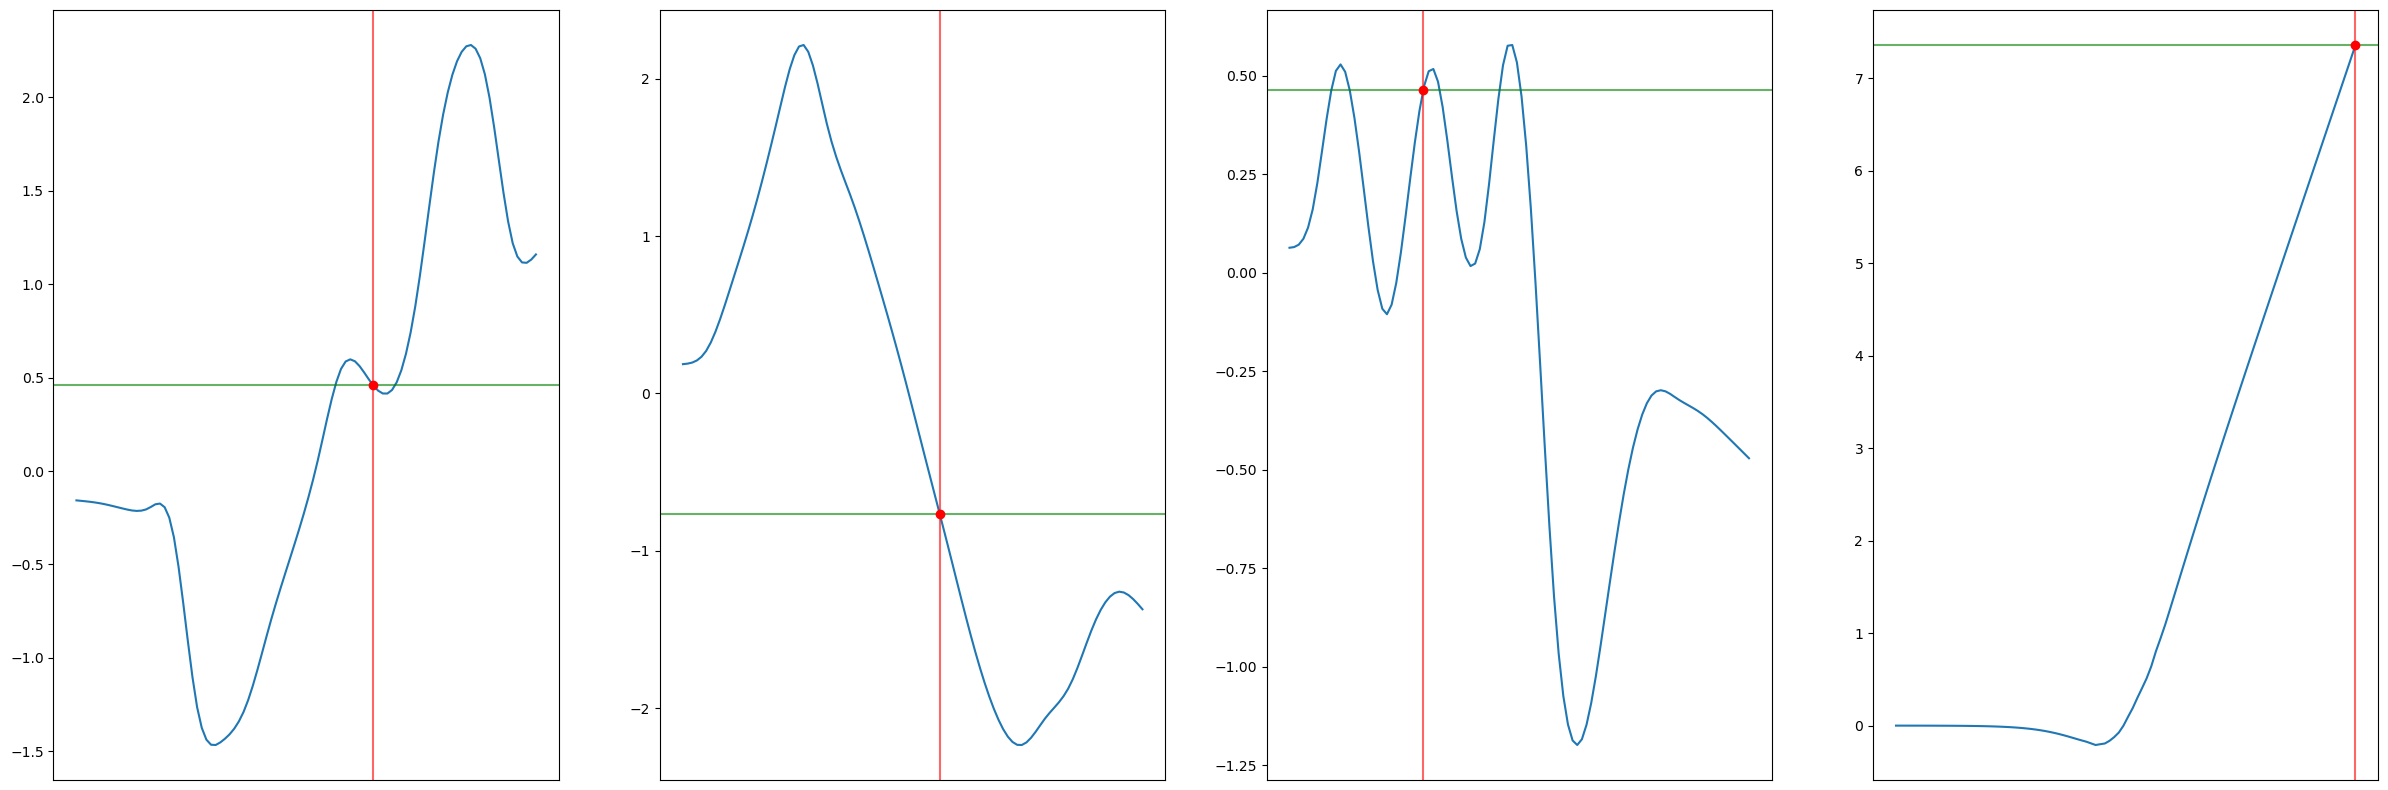

Predizione della rete: 7.518395096063614, label reale: 8.0


In [11]:
fig, axes = plt.subplots(layer2_dim, layer1_dim, figsize=(30, 10), squeeze=False)

spline_list_1 = model.layers[1].get_spline_list()

layer2_output = 0

for i in range(layer2_dim):
    for j in range(layer1_dim):

        xx = np.linspace(-2, 2, 100) if -2 <= layer1_output[j] <= 2 else np.linspace(-abs(layer1_output[j]), abs(layer1_output[j]), 100)
        yy = spline_list_1[j][i](tf.convert_to_tensor(xx, dtype=tf.float32))
        axes[i][j].plot(xx, yy)
        axes[i][j].set_xticks([])
        axes[i][j].axvline(x=layer1_output[j], color='red', alpha=0.6)
        axes[i][j].axhline(y=spline_list_1[j][i](layer1_output[j]), color='green', alpha=0.6)
        axes[i][j].plot(layer1_output[j], spline_list_1[j][i](layer1_output[j]), 'ro')
        layer2_output += spline_list_1[j][i](layer1_output[j])

plt.show()

print(f"Predizione della rete: {layer2_output}, label reale: {y_train[8]}")